In [1]:
from langchain_openai import ChatOpenAI, OpenAIEmbeddings

In [2]:
from langgraph.prebuilt import create_react_agent

In [3]:
from langchain.vectorstores import FAISS

In [4]:
from langchain.document_loaders import PyPDFLoader

In [5]:
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from langchain_core.runnables import RunnablePassthrough
from langchain.chains.combine_documents import create_stuff_documents_chain
from langchain_core.messages import HumanMessage

In [6]:
from langgraph.prebuilt import create_react_agent

In [7]:
from typing import Dict

In [8]:
from config import Settings

In [16]:
import os

### Create the Embeddings

We create the embeddings from the earnings cal transcriptions

In [17]:
api_key = Settings.api_key
VECTOR_DIR = 'vectorize'
embeddings = OpenAIEmbeddings(
    model="text-embedding-ada-002",
    api_key=api_key)

In [64]:
file_paths = ["data/nvidia_10k_21.pdf", "data/lyft_10k_21.pdf"]

for file_path in file_paths:
    loader = PyPDFLoader(file_path)
    document = loader.load()
    company_name = file_path.split("/")[1].split("_")[0]
    print("Company: ", company_name)
    save_dir = VECTOR_DIR + "/" + company_name
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)
    vector_store = FAISS.from_documents(document, embeddings)
    vector_store.save_local(save_dir)

Company:  nvidia


In [70]:
llm = ChatOpenAI(model="gpt-4o", api_key=api_key)

SYSTEM_TEMPLATE = """
    Answer the user's questions based on the below context. 
    If the context doesn't contain any relevant information to the questions, don't make someting up
    and just reply information cannot be fount:
    <context>
    {context}
    </context>
    """

In [71]:
def parse_retriever_input(params: Dict):
    return params["messages"][-1].content

def contextualQA(earnings_question: str, company_name: str) -> str:

    """
    Identifies the relevant context in the earning call transcripts to the user question

    This tool searches in the earnings calls transcript documents and extract financial information
    such as net income, REvenue, EBITDA and etc.

    Parameters:
    - earnings_question: The questions asked by the user
    - the company for which we need to answer the question. Company names should always be lowercase

    Returns:
    - A string with the context that contain the answer to the earnings question.
    """
    vector_store = FAISS.load_local(VECTOR_DIR + "/" + company_name, 
                                    embeddings, 
                                    allow_dangerous_deserialization=True)
    retriever = vector_store.as_retriever()
    qa_prompt = ChatPromptTemplate.from_messages(
        [
            ("system", SYSTEM_TEMPLATE),
            MessagesPlaceholder(variable_name="messages"),
        ]
    )
    qa_chain = create_stuff_documents_chain(llm, qa_prompt)
    retrieval_chain = RunnablePassthrough.assign(
    context = parse_retriever_input | retriever).assign(answer=qa_chain)
    response = retrieval_chain.invoke(
        {
            "messages": [HumanMessage(content=earnings_question)]
        }
    )
    return response["answer"]


In [65]:
print(contextualQA("what is the total for nvidia in 2020?", "nvidia"))

The total revenue for NVIDIA in fiscal year 2020 was $10.92 billion.


In [72]:
tools = [contextualQA]

prompt = "You are a helpful assistant capable to compare earning information between companies."
agent_executor = create_react_agent(llm, tools, prompt=prompt)
agent_executor.invoke({"messages": [("user", "what is the difference in the total revenue between Nvidia and Lyft in 2020?")]})

In [73]:
import operator
from typing import Annotated, List, Tuple
from typing_extensions import TypedDict


class PlanExecute(TypedDict):
    input: str
    plan: List[str]
    past_steps: Annotated[List[Tuple], operator.add]
    response: str

In [74]:
from pydantic import BaseModel, Field


class Plan(BaseModel):
    """Plan to follow in future"""

    steps: List[str] = Field(
        description="different steps to follow, should be in sorted order"
    )

In [75]:
from langchain_core.prompts import ChatPromptTemplate

planner_prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            """For the given objective, come up with a simple step by step plan. \
This plan should involve individual tasks, that if executed correctly will yield the correct answer. Do not add any superfluous steps. \
The result of the final step should be the final answer. Make sure that each step has all the information needed - do not skip steps.""",
        ),
        ("placeholder", "{messages}"),
    ]
)
planner = planner_prompt | ChatOpenAI(model="gpt-4o", temperature=0).with_structured_output(Plan)

In [35]:
planner.invoke(
    {
        "messages": [
            ("user", "what was the difference in the total revenue between uber and lyft in 2020?")
        ]
    }
)

Plan(steps=['Find the total revenue for Uber in 2020.', 'Find the total revenue for Lyft in 2020.', "Calculate the difference between Uber's total revenue and Lyft's total revenue."])

In [77]:
from typing import Union


class Response(BaseModel):
    """Response to user."""

    response: str


class Act(BaseModel):
    """Action to perform."""

    action: Union[Response, Plan] = Field(
        description="Action to perform. If you want to respond to user, use Response. "
        "If you need to further use tools to get the answer, use Plan."
    )


replanner_prompt = ChatPromptTemplate.from_template(
    """For the given objective, come up with a simple step by step plan.
    This plan should involve individual tasks, that if executed correctly will yield the correct answer. Do not add any superfluous steps. \
    The result of the final step should be the final answer. Make sure that each step has all the information needed - do not skip steps.
    Your objective was this:
    {input}
    
    Your original plan was this:
    {plan}
    
    You have currently done the follow steps:
    {past_steps}
    
    Update your plan accordingly. If no more steps are needed and you can return to the user, then respond with that. Otherwise, fill out the plan. Only add steps to the plan that still NEED to be done. Do not return previously done steps as part of the plan."""
)


replanner = replanner_prompt | ChatOpenAI(model="gpt-4o", temperature=0).with_structured_output(Act)

In [78]:
from typing import Literal
from langgraph.graph import END


async def execute_step(state: PlanExecute):
    plan = state["plan"]
    plan_str = "\n".join(f"{i+1}. {step}" for i, step in enumerate(plan))
    task = plan[0]
    task_formatted = f"""For the following plan:
{plan_str}\n\nYou are tasked with executing step {1}, {task}."""
    agent_response = await agent_executor.ainvoke(
        {"messages": [("user", task_formatted)]}
    )
    return {
        "past_steps": [(task, agent_response["messages"][-1].content)],
    }


async def plan_step(state: PlanExecute):
    plan = await planner.ainvoke({"messages": [("user", state["input"])]})
    return {"plan": plan.steps}


async def replan_step(state: PlanExecute):
    output = await replanner.ainvoke(state)
    if isinstance(output.action, Response):
        return {"response": output.action.response}
    else:
        return {"plan": output.action.steps}


def should_end(state: PlanExecute):
    if "response" in state and state["response"]:
        return END
    else:
        return "agent"

In [79]:
from langgraph.graph import StateGraph, START

workflow = StateGraph(PlanExecute)

# Add the plan node
workflow.add_node("planner", plan_step)

# Add the execution step
workflow.add_node("agent", execute_step)

# Add a replan node
workflow.add_node("replan", replan_step)

workflow.add_edge(START, "planner")

# From plan we go to agent
workflow.add_edge("planner", "agent")

# From agent, we replan
workflow.add_edge("agent", "replan")

workflow.add_conditional_edges(
    "replan",
    # Next, we pass in the function that will determine which node is called next.
    should_end,
    ["agent", END],
)

# Finally, we compile it!
# This compiles it into a LangChain Runnable,
# meaning you can use it as you would any other runnable
app = workflow.compile()

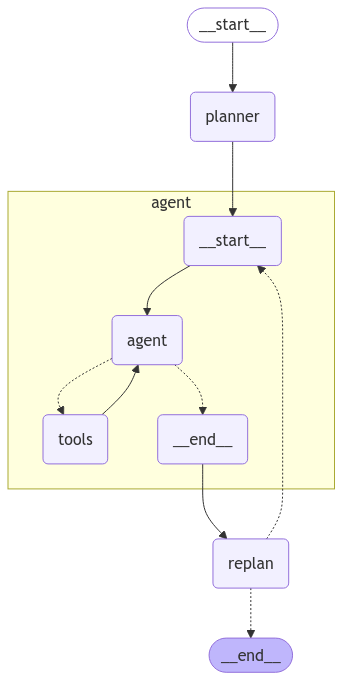

In [80]:
from IPython.display import Image, display

display(Image(app.get_graph(xray=True).draw_mermaid_png()))

In [81]:
config = {"recursion_limit": 20}
inputs = {"input": "what was the difference in the total revenue between Nvidia and Lyft in 2020?"}
async for event in app.astream(inputs, config=config):
    for k, v in event.items():
        if k != "__end__":
            print(v)

{'plan': ["Find the total revenue for Nvidia in 2020. This information can be found in Nvidia's 2020 annual financial report or a reliable financial database.", "Find the total revenue for Lyft in 2020. This information can be found in Lyft's 2020 annual financial report or a reliable financial database.", 'Subtract the total revenue of Lyft from the total revenue of Nvidia to find the difference.']}
{'past_steps': [("Find the total revenue for Nvidia in 2020. This information can be found in Nvidia's 2020 annual financial report or a reliable financial database.", 'The total revenue for Nvidia in 2020 was $10.918 billion.')]}
{'plan': ["Find the total revenue for Lyft in 2020. This information can be found in Lyft's 2020 annual financial report or a reliable financial database.", 'Subtract the total revenue of Lyft from the total revenue of Nvidia to find the difference.']}
{'past_steps': [("Find the total revenue for Lyft in 2020. This information can be found in Lyft's 2020 annual f